In [1]:
## Check GPU ##
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
1.13.1


In [3]:
ls

anaconda3/                   cars_test.tgz   Nvidia_Cloud_EULA.pdf  tools/
car_devkit.tgz               cars_train.tgz  README                 tutorials/
Cars (Submission) (2).ipynb  examples/       src/


In [4]:
# Pre-Processing Steps taken from foamliu on his github repo
# https://github.com/foamliu/Car-Recognition/blob/master/pre-process.py


import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder = 'cars_train'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'data/test'
    num_samples = len(fnames)


    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    print('Extracting cars_train.tgz...')
    if not os.path.exists('cars_train'):
        with tarfile.open('cars_train.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting cars_test.tgz...')
    if not os.path.exists('cars_test'):
        with tarfile.open('cars_test.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting car_devkit.tgz...')
    if not os.path.exists('devkit'):
        with tarfile.open('car_devkit.tgz', "r:gz") as tar:
            tar.extractall()

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('data/train')
    ensure_folder('data/valid')
    ensure_folder('data/test')

    process_train_data()
    process_test_data()

    # clean up
    shutil.rmtree('cars_train')
    shutil.rmtree('cars_test')
    # shutil.rmtree('devkit')

Extracting cars_train.tgz...
Extracting cars_test.tgz...
Extracting car_devkit.tgz...
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The numbe

In [5]:
ls data

test/  train/  valid/


In [6]:
## Parameters ###

batch_size = 48

img_width = 224
img_height = 224

dropout_rate = 0.2
input_shape = (img_height, img_width, 3)

train_data = 'data/train' ## create directory for data generator
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
num_epochs = 20
verbose = 1

In [7]:
### Image Augmentation and Geneartor

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# prepare data augmentation configuration
train_data_gen = ImageDataGenerator(rotation_range=20.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True)
    
valid_data_gen = ImageDataGenerator()
    


# generators
train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height),shuffle=True, batch_size=batch_size,
                                                         class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height),shuffle=True, batch_size=batch_size,
                                                         class_mode='categorical')
      

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


# Efficient Nets


In [8]:
ls

anaconda3/                   cars_train.tgz  Nvidia_Cloud_EULA.pdf  tutorials/
car_devkit.tgz               data/           README
Cars (Submission) (2).ipynb  devkit/         src/
cars_test.tgz                examples/       tools/


In [9]:
### Efficient Nets ####

import os
%cd /home/ubuntu
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/home/ubuntu
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 171 (delta 98), reused 161 (delta 93), pack-reused 0
Receiving objects: 100% (171/171), 5.44 MiB | 937.00 KiB/s, done.
Resolving deltas: 100% (98/98), done.
Checking connectivity... done.
/home/ubuntu/efficientnet_keras_transfer_learning


In [23]:
%cd /home/ubuntu/efficientnet_keras_transfer_learning
#Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

# loading pretrained conv base model
conv_base = Net(weights="imagenet", include_top=False, input_shape=input_shape)

/home/ubuntu/efficientnet_keras_transfer_learning


In [24]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_49 (Batc (None, 112, 112, 32) 128         conv2d_65[0][0]                  
__________________________________________________________________________________________________
swish_49 (Swish)                (None, 112, 112, 32) 0           batch_normalization_v1_49[0][0]  
__________________________________________________________________________________________________
depthwise_

In [25]:
### Adding last few layers ########

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers


model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(196, activation='softmax', name="fc_out"))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 196)               251076    
Total params: 4,300,640
Trainable params: 4,258,624
Non-trainable params: 42,016
_________________________________________________________________


In [27]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


In [29]:
## Change back to working directory ####
%cd /home/ubuntu

/home/ubuntu


In [30]:
ls

anaconda3/                   data/                                  README
car_devkit.tgz               devkit/                                src/
Cars (Submission) (2).ipynb  efficientnet_keras_transfer_learning/  tools/
cars_test.tgz                examples/                              tutorials/
cars_train.tgz               Nvidia_Cloud_EULA.pdf


In [31]:
## Train Model ##

history= model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        verbose=verbose,
        use_multiprocessing=True,
        workers=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
136/136 [==============================] - 76s 558ms/step - loss: 12.0698 - acc: 0.0046 - val_loss: 10.0007 - val_acc: 0.0055
Epoch 2/20
136/136 [==============================] - 21s 156ms/step - loss: 11.3132 - acc: 0.0068 - val_loss: 9.2698 - val_acc: 0.0074
Epoch 3/20
136/136 [==============================] - 21s 155ms/step - loss: 10.8643 - acc: 0.0058 - val_loss: 8.9148 - val_acc: 0.0055
Epoch 4/20
136/136 [==============================] - 21s 156ms/step - loss: 10.6844 - acc: 0.0061 - val_loss: 8.6967 - val_acc: 0.0055
Epoch 5/20
136/136 [==============================] - 21s 158ms/step - loss: 10.5526 - acc: 0.0054 - val_loss: 8.5538 - val_acc: 0.0061
Epoch 6/20
136/136 [==============================] - 21s 158ms/step - loss: 10.4190 - acc: 0.0064 - val_loss: 8.4590 - val_acc: 0.0068
Epoch 7/20
136/136 [==============================] - 21s 156ms/step - loss: 10.3232 - acc: 0.0074 - val_loss: 8.3964 - val_acc: 0.0074

# Load model

In [32]:
import os
os.makedirs("./models", exist_ok=True)
model.save('./cars.h5')

In [33]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [34]:
## Loading previously trained weights
from tensorflow.keras.models import load_model
model = load_model("/home/ubuntu/carsv6_small.h5")

# Fine-Tuning

In [35]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [36]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

efficientnet-b0  Trainable = True
gap  Trainable = True
dropout_out  Trainable = True
fc_out  Trainable = True


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 196)               251076    
Total params: 4,300,640
Trainable params: 251,076
Non-trainable params: 4,049,564
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


In [39]:
history= model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        verbose=verbose,
        use_multiprocessing=True,
        workers=8)

Epoch 1/20
136/136 [==============================] - 24s 175ms/step - loss: 0.4001 - acc: 0.9054 - val_loss: 0.1773 - val_acc: 0.9583
Epoch 2/20
136/136 [==============================] - 21s 153ms/step - loss: 0.3909 - acc: 0.9070 - val_loss: 0.1771 - val_acc: 0.9583
Epoch 3/20
136/136 [==============================] - 21s 153ms/step - loss: 0.3925 - acc: 0.9119 - val_loss: 0.1775 - val_acc: 0.9589
Epoch 4/20
136/136 [==============================] - 21s 152ms/step - loss: 0.3845 - acc: 0.9071 - val_loss: 0.1783 - val_acc: 0.9576
Epoch 5/20
136/136 [==============================] - 21s 153ms/step - loss: 0.3874 - acc: 0.9054 - val_loss: 0.1779 - val_acc: 0.9589
Epoch 6/20
136/136 [==============================] - 21s 155ms/step - loss: 0.3843 - acc: 0.9136 - val_loss: 0.1775 - val_acc: 0.9576
Epoch 7/20
136/136 [==============================] - 21s 155ms/step - loss: 0.3796 - acc: 0.9099 - val_loss: 0.1777 - val_acc: 0.9558
Epoch 8/20
136/136 [==============================] - 2

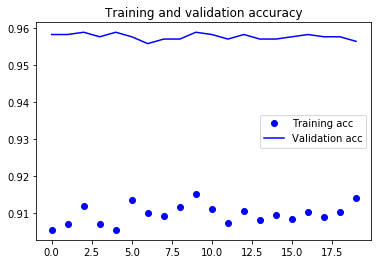

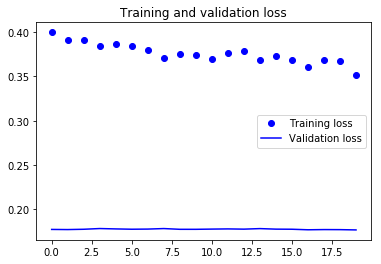

In [41]:
## Plot Training and validation accuracy
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test Predict

In [52]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

image_path = './data/test/'
img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./data/test/01748.jpg
Input image shape: (1, 224, 224, 3)


In [53]:
# import the necessary packages
import json
import os
import random

import cv2 as cv
import keras.backend as K
import numpy as np
import scipy.io


if __name__ == '__main__':
    img_width, img_height = 224, 224

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)

    test_path = 'data/test/'
    test_images = [f for f in os.listdir(test_path) if
                   os.path.isfile(os.path.join(test_path, f)) and f.endswith('.jpg')]

    num_samples = 20
    samples = random.sample(test_images, num_samples)
    results = []
    for i, image_name in enumerate(samples):
        filename = os.path.join(test_path, image_name)
        print('Start processing image: {}'.format(filename))
        bgr_img = cv.imread(filename)
        bgr_img = cv.resize(bgr_img, (img_width, img_height), cv.INTER_CUBIC)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        text = ('Predict: {}, prob: {}'.format(class_names[class_id][0][0], prob))
        results.append({'label': class_names[class_id][0][0], 'prob': '{:.4}'.format(prob)})
        cv.imwrite('images/{}_out.png'.format(i), bgr_img)

    print(results)
    with open('results.json', 'w') as file:
        json.dump(results, file, indent=4)

    K.clear_session()


Start processing image: data/test/07871.jpg
Start processing image: data/test/04881.jpg
Start processing image: data/test/01738.jpg
Start processing image: data/test/02274.jpg
Start processing image: data/test/00813.jpg
Start processing image: data/test/06471.jpg
Start processing image: data/test/03706.jpg
Start processing image: data/test/06363.jpg
Start processing image: data/test/07538.jpg
Start processing image: data/test/02860.jpg
Start processing image: data/test/06638.jpg
Start processing image: data/test/00071.jpg
Start processing image: data/test/05803.jpg
Start processing image: data/test/02942.jpg
Start processing image: data/test/01054.jpg
Start processing image: data/test/03796.jpg
Start processing image: data/test/07569.jpg
Start processing image: data/test/05583.jpg
Start processing image: data/test/05445.jpg
Start processing image: data/test/04766.jpg
[{'label': 'HUMMER H3T Crew Cab 2010', 'prob': '0.9869'}, {'label': 'Dodge Journey SUV 2012', 'prob': '0.9358'}, {'label

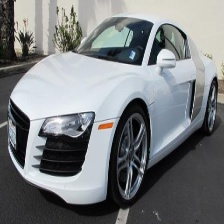

In [59]:
from IPython.display import Image
image_path = './data/test/'
image_check = '05018.jpg'

Image(image_path+image_check)